# 応用編

## 準備：モジュールの読み込み

今度は，データハンドリングや比較プロットのため，`pygmt`だけでなく `numpy`と`ObsPy` も入れておくことにします．特に，ObsPyの`UTCDateTime`モジュールは時刻の扱いに有用なようなので，単独でインポートしておきます．

In [1]:
import pygmt

In [2]:
# その他のモジュール
import numpy as np
import obspy
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import datetime

## 地形段彩図の描画

手持ちのNetCDF（`grd` or `nc`）ファイルを描画するのはもちろん，GMT6からはネットワーク越しにグローバルな地形データを取得するコマンドが提供されています．そこで，ここではその `pygmt` 版を用いて，地形図の描画を行います．

In [3]:
grid_data = pygmt.datasets.load_earth_relief(
    resolution='01m',
    region = [128, 150, 28, 50]
)

上記のコマンドで，`region` で指定した地域の地形を `resolution` の解像度で読み込み，左辺の変数（`grid_data`）に格納します．この変数を用いてあとで地形図を作成します．

`region`の指定方法はこれまでと同じです．省略した場合にはグローバルデータが読み込まれます．

`resolution`は `01d`, `30m`, `20m`, `15m`, `10m`, `06m`, `05m`, `04m`, `03m`, `02m`, `01m`, `30s`, `15s`, `03s`, `01s` から，つまり1秒角から1度までのうちからどれか一つを選びます．

ダウンロードされるデータはSRTM（Shuttle Rader Topography Mission）で，解像度によりデータソース（提供年）が異なるようです．また，1秒と3秒グリッドには海底地形データが存在しないため，15秒データから補間されます．ダウンロードしたデータは `~/.gmt/` 以下にキャッシュされます．あまり細かいグリッドで広域のデータを読み込むと，ダウンロードにもプロットにも時間がかかるので，注意してください．

段彩図をより見栄え良くするには，`grdgradient`による傾斜データの作成と利用が有効です．

In [4]:
gradient_data = pygmt.grdgradient(
    grid      = grid_data,
    azimuth   = [45, 135], 
    normalize = 'e0.7'
)

GMTの `grdgradient` と同じですが，地形の可視化に用いる場合には方角 `azimuth` を複数方向の組み合わせにし，かつ `normalize` を上記の例程度の値にしておくのが良いようです．

```{admonition} ToDo
[Demo](https://www.pygmt.org/dev/gallery/images/grdgradient.html#sphx-glr-gallery-images-grdgradient-py)を見ると，`radiance`パラメータにより計算した`grd`データで地形可視化を行っている．要調査．
```

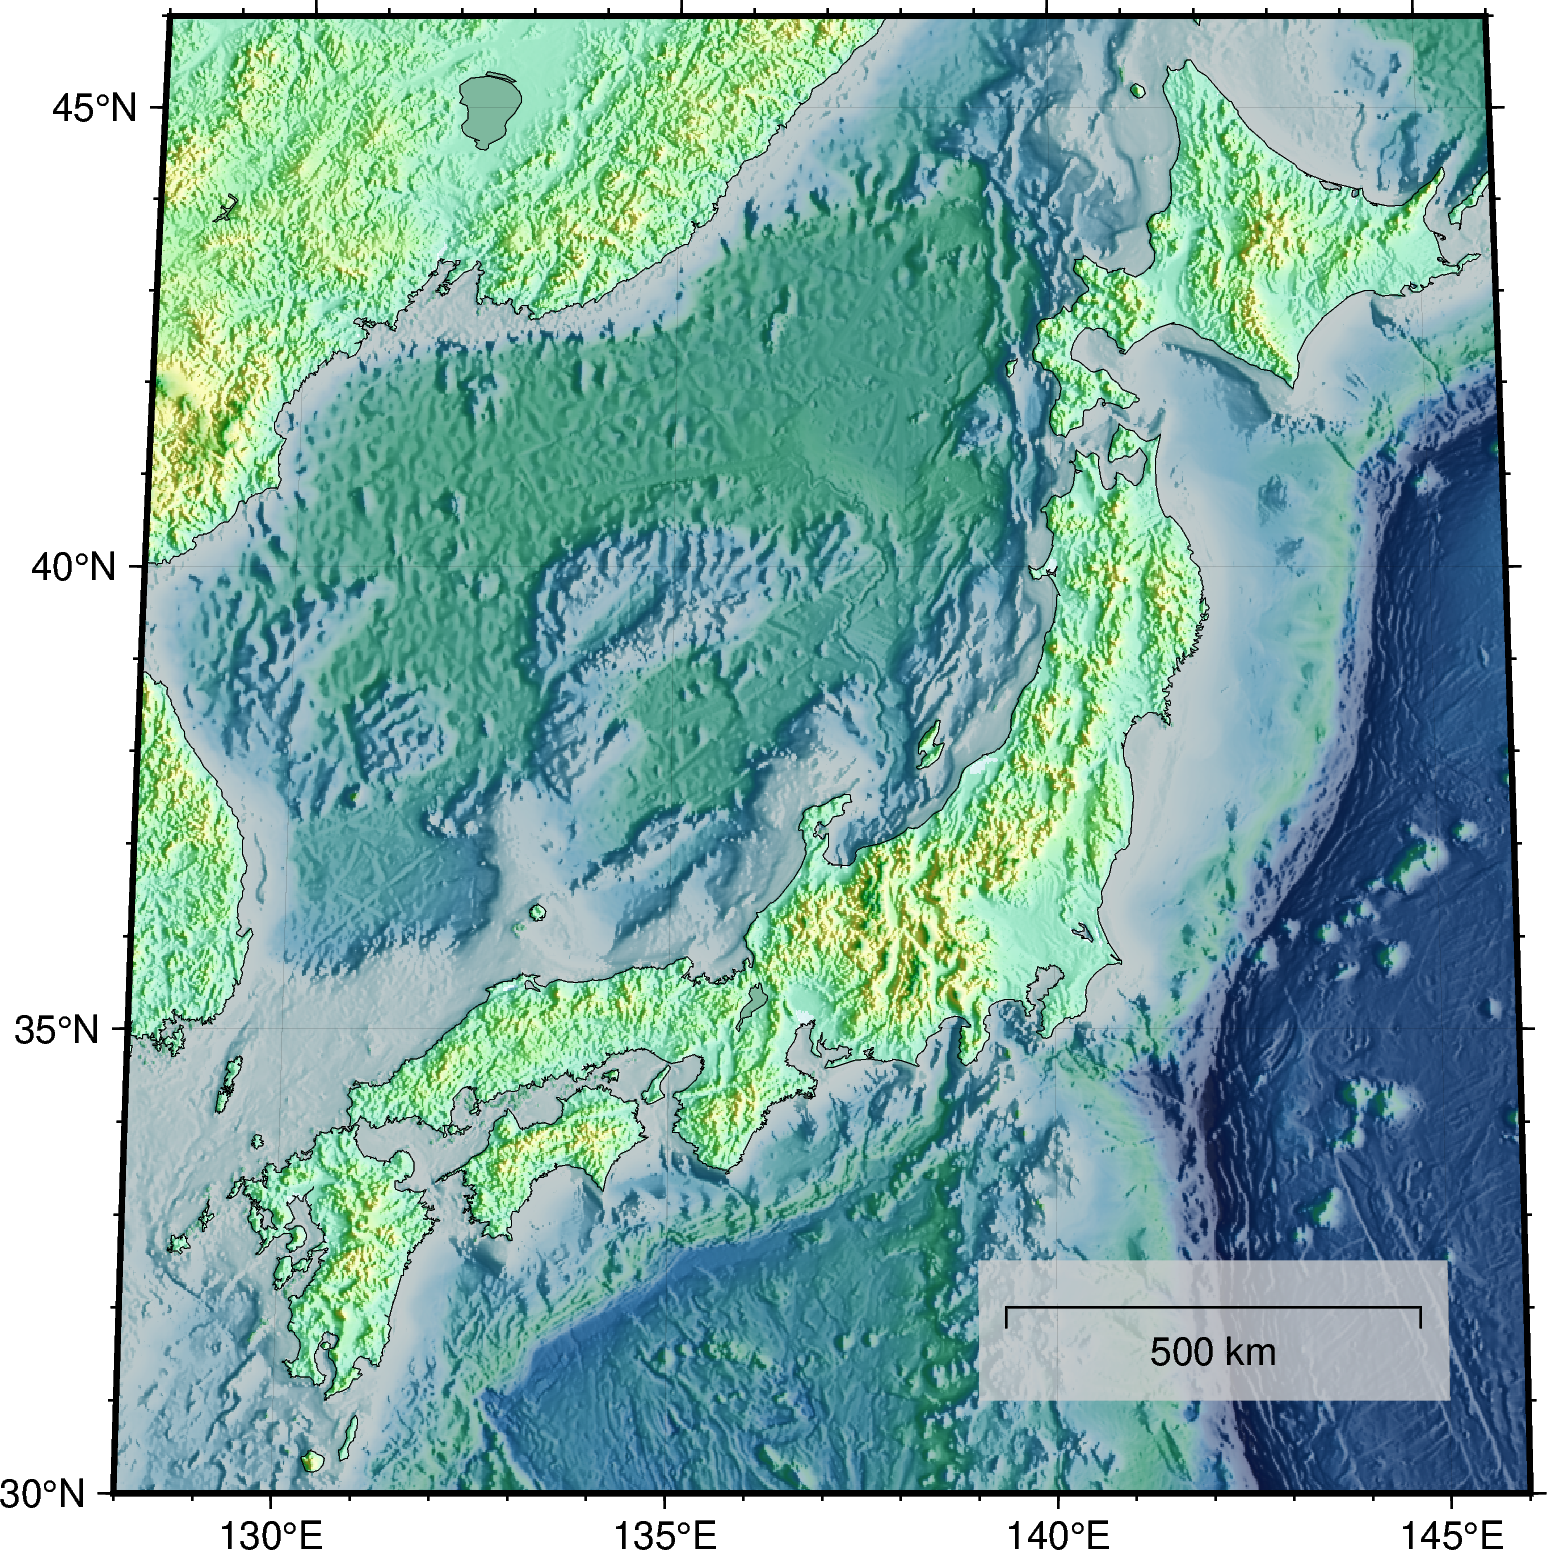

In [5]:
fig = pygmt.Figure()

# カラーマップ作成．以降ではこのCPTが自動的に使われる．
pygmt.makecpt(
    cmap = 'earth', 
)

# 標高と斜度データを可視化
fig.grdimage(
    projection = 'N138/12c', 
    region     = [128, 146, 30, 46], 
    grid       = grid_data, 
    shading    = gradient_data
)

# 距離スケールの背景のための領域
fig.plot(
    data = [[139, 31], [145,31], [145,32.5], [139,32.5]], 
    color = 'white',
    transparency = 20,
    straight_line = True    
)

# 海岸線描画と海域を半透明シェーディング
fig.coast(
    area_thresh = '100', 
    map_scale   = '142/32/32/500',
    shorelines  = 'faint,black',
    water       = 'black@80',
    frame       = ['WSen', 'xaf', 'yaf']
)

fig.show()

ここでは，見た目を向上させるテクニックを2つほど使っています．どちらもPyGMT以外の話題も含みますが，すこし詳しく解説しておきましょう．

まず，単に `fig.grdimage` で色を塗るだけでなく，その上に海岸線を描画しています．さらに，この例で用いた `earth` カラーパレットは陸域と海域の差が目立たなかったため，`fig.coast` の `water` で透明度80%の黒色（`black@80`）で海域を塗りつぶすことで，相対的に陸域が浮かび上がって見えるように工夫しています．色名のあとの`@`は透明度指定で，100に近いほど透明度が高くなります．`water = 'black@80` の行をコメントアウトして実行してみると，その差が実感できるでしょう．ただし，このテクニックを使うともとの色を改変することになりますので，カラースケールを表示してもその色が正確ではなくなりますので，注意が必要です．

一方，地図の距離スケール（`fig.pscoast`の`map-scale`オプション）をカラフルなカラーマップ上に描画すると，視認性がとても低くなってしまいます．そこで，`fig.plot()` で四角形の頂点を与え，半透明の白い「箱」を先に描画しています．これは順番が大事で，`fig.coast()`の**前**に予め箱を描画しておかないと，せっかくの地図スケールを塗りつぶしてしまうことになりかねません．`fig.plot()` には四隅の頂点を2次元配列として `data=` オプションに与えていますが，x軸とy軸の1次元配列を個別に `x = `, `y = ` として与えることもできます．なお，地図上に頂点を指定してポリゴンを描画すると，デフォルトではその辺が地図上の大円経路に沿った線として描画されます．結果として，地図投影上は曲がった線に見えてしまいます．これを避けているのが` straight_line = True` オプションです．

## XYグラフ

本家GMTと同じく，投影法（`projection`）に `X` を選ぶことで，直交座標系のXYグラフを作成することができます．

### シンボルのプロット

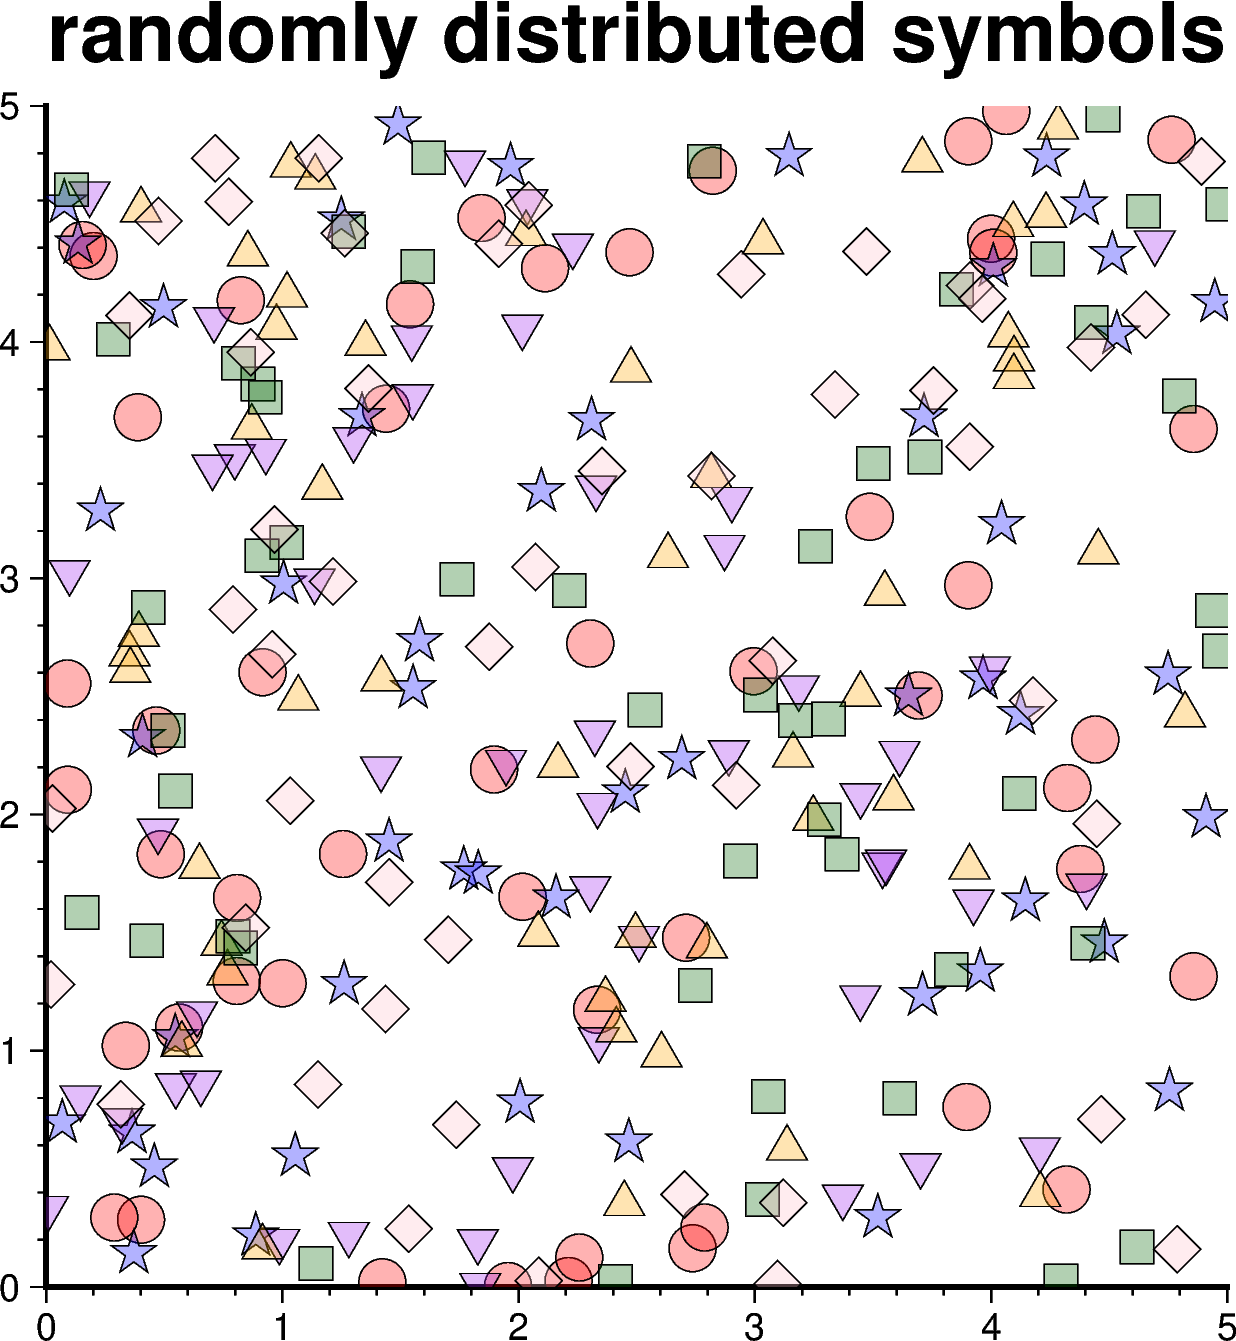

In [6]:
n = 50

fig = pygmt.Figure()

# シンボルの種類と色
symb = ['c',   'a',    'i',      't',      's',         'd']    
col  = ['red', 'blue', 'purple', 'orange', 'darkgreen', 'pink']

fig.basemap(
    projection = 'X10c/10c', 
    region     = [0, 5, 0, 5], 
    frame      = ['WS+t"randomly distributed symbols"', 'xaf', 'yaf']
)

for i in range(len(symb)):
    
    dat = 5 * np.random.rand(n,n)

    fig.plot(
        data  = dat, 
        style = symb[i] + '0.4c', 
        color = col[i] + '@70',
        pen   = 'default,black'
    )


fig.show()

新しいコマンド `fig.plot()` では `style` でシンボルや（固定サイズの場合は）サイズの指定を行います．

シンボルは[GMT公式ドキュメント](https://docs.generic-mapping-tools.org/latest/plot.html)の以下の図の通り：
<img src="https://docs.generic-mapping-tools.org/latest/_images/GMT_base_symbols1.png">

上記の例は，変数 `symb` にシンボル種類を格納し，ループ内で `x` `y` 座標を乱数（`np.random.rand`）によって生成してプロットを行っています．

## 地図上への情報描画

### データの準備

pygmtが用意しているexampleデータに日本列島周辺の地震情報がありますので，それを題材にしてプロットしてみましょう．

In [7]:
hypdata = pygmt.datasets.load_japan_quakes()

上記コマンドはデモンストレーション用のデータセットの読み込みの専用コマンドです．オンラインからデータを読み込むので多少時間がかかります．

震源情報は，pandasのデータフレームとして変数 `data` に格納されます．ただしここではpandasの細かい利用法を意識する必要はありません．`print`してみると，ほどよく途中を省略してデータフレームの概略を表示してくれます．

In [8]:
print(hypdata)

     year  month  day  latitude  longitude  depth_km  magnitude
0    1987      1    4     49.77     149.29       489        4.1
1    1987      1    9     39.90     141.68        67        6.8
2    1987      1    9     39.82     141.64        84        4.0
3    1987      1   14     42.56     142.85       102        6.5
4    1987      1   16     42.79     145.10        54        5.1
..    ...    ...  ...       ...        ...       ...        ...
110  1988     11   10     35.32     140.88        10        4.0
111  1988     11   29     35.88     141.47        46        4.0
112  1988     12    3     43.53     146.98        39        4.3
113  1988     12   20     43.94     146.13       114        4.5
114  1988     12   21     42.02     142.45        73        4.5

[115 rows x 7 columns]


Pandasのデータフレームは表形式で複数の列が名前付きで含まれていることがわかるでしょう．このなかから特定の列のデータを取り出すには，たとえば
```python
data.year
```
のように `変数名.列名` とします．

### 固定サイズ単一色のプロット

まずは単純シンボルプロットから行いましょう．
`fig.plot` で x軸（経度方向）とy軸（緯度方向）のデータ配列を個別に指定します．

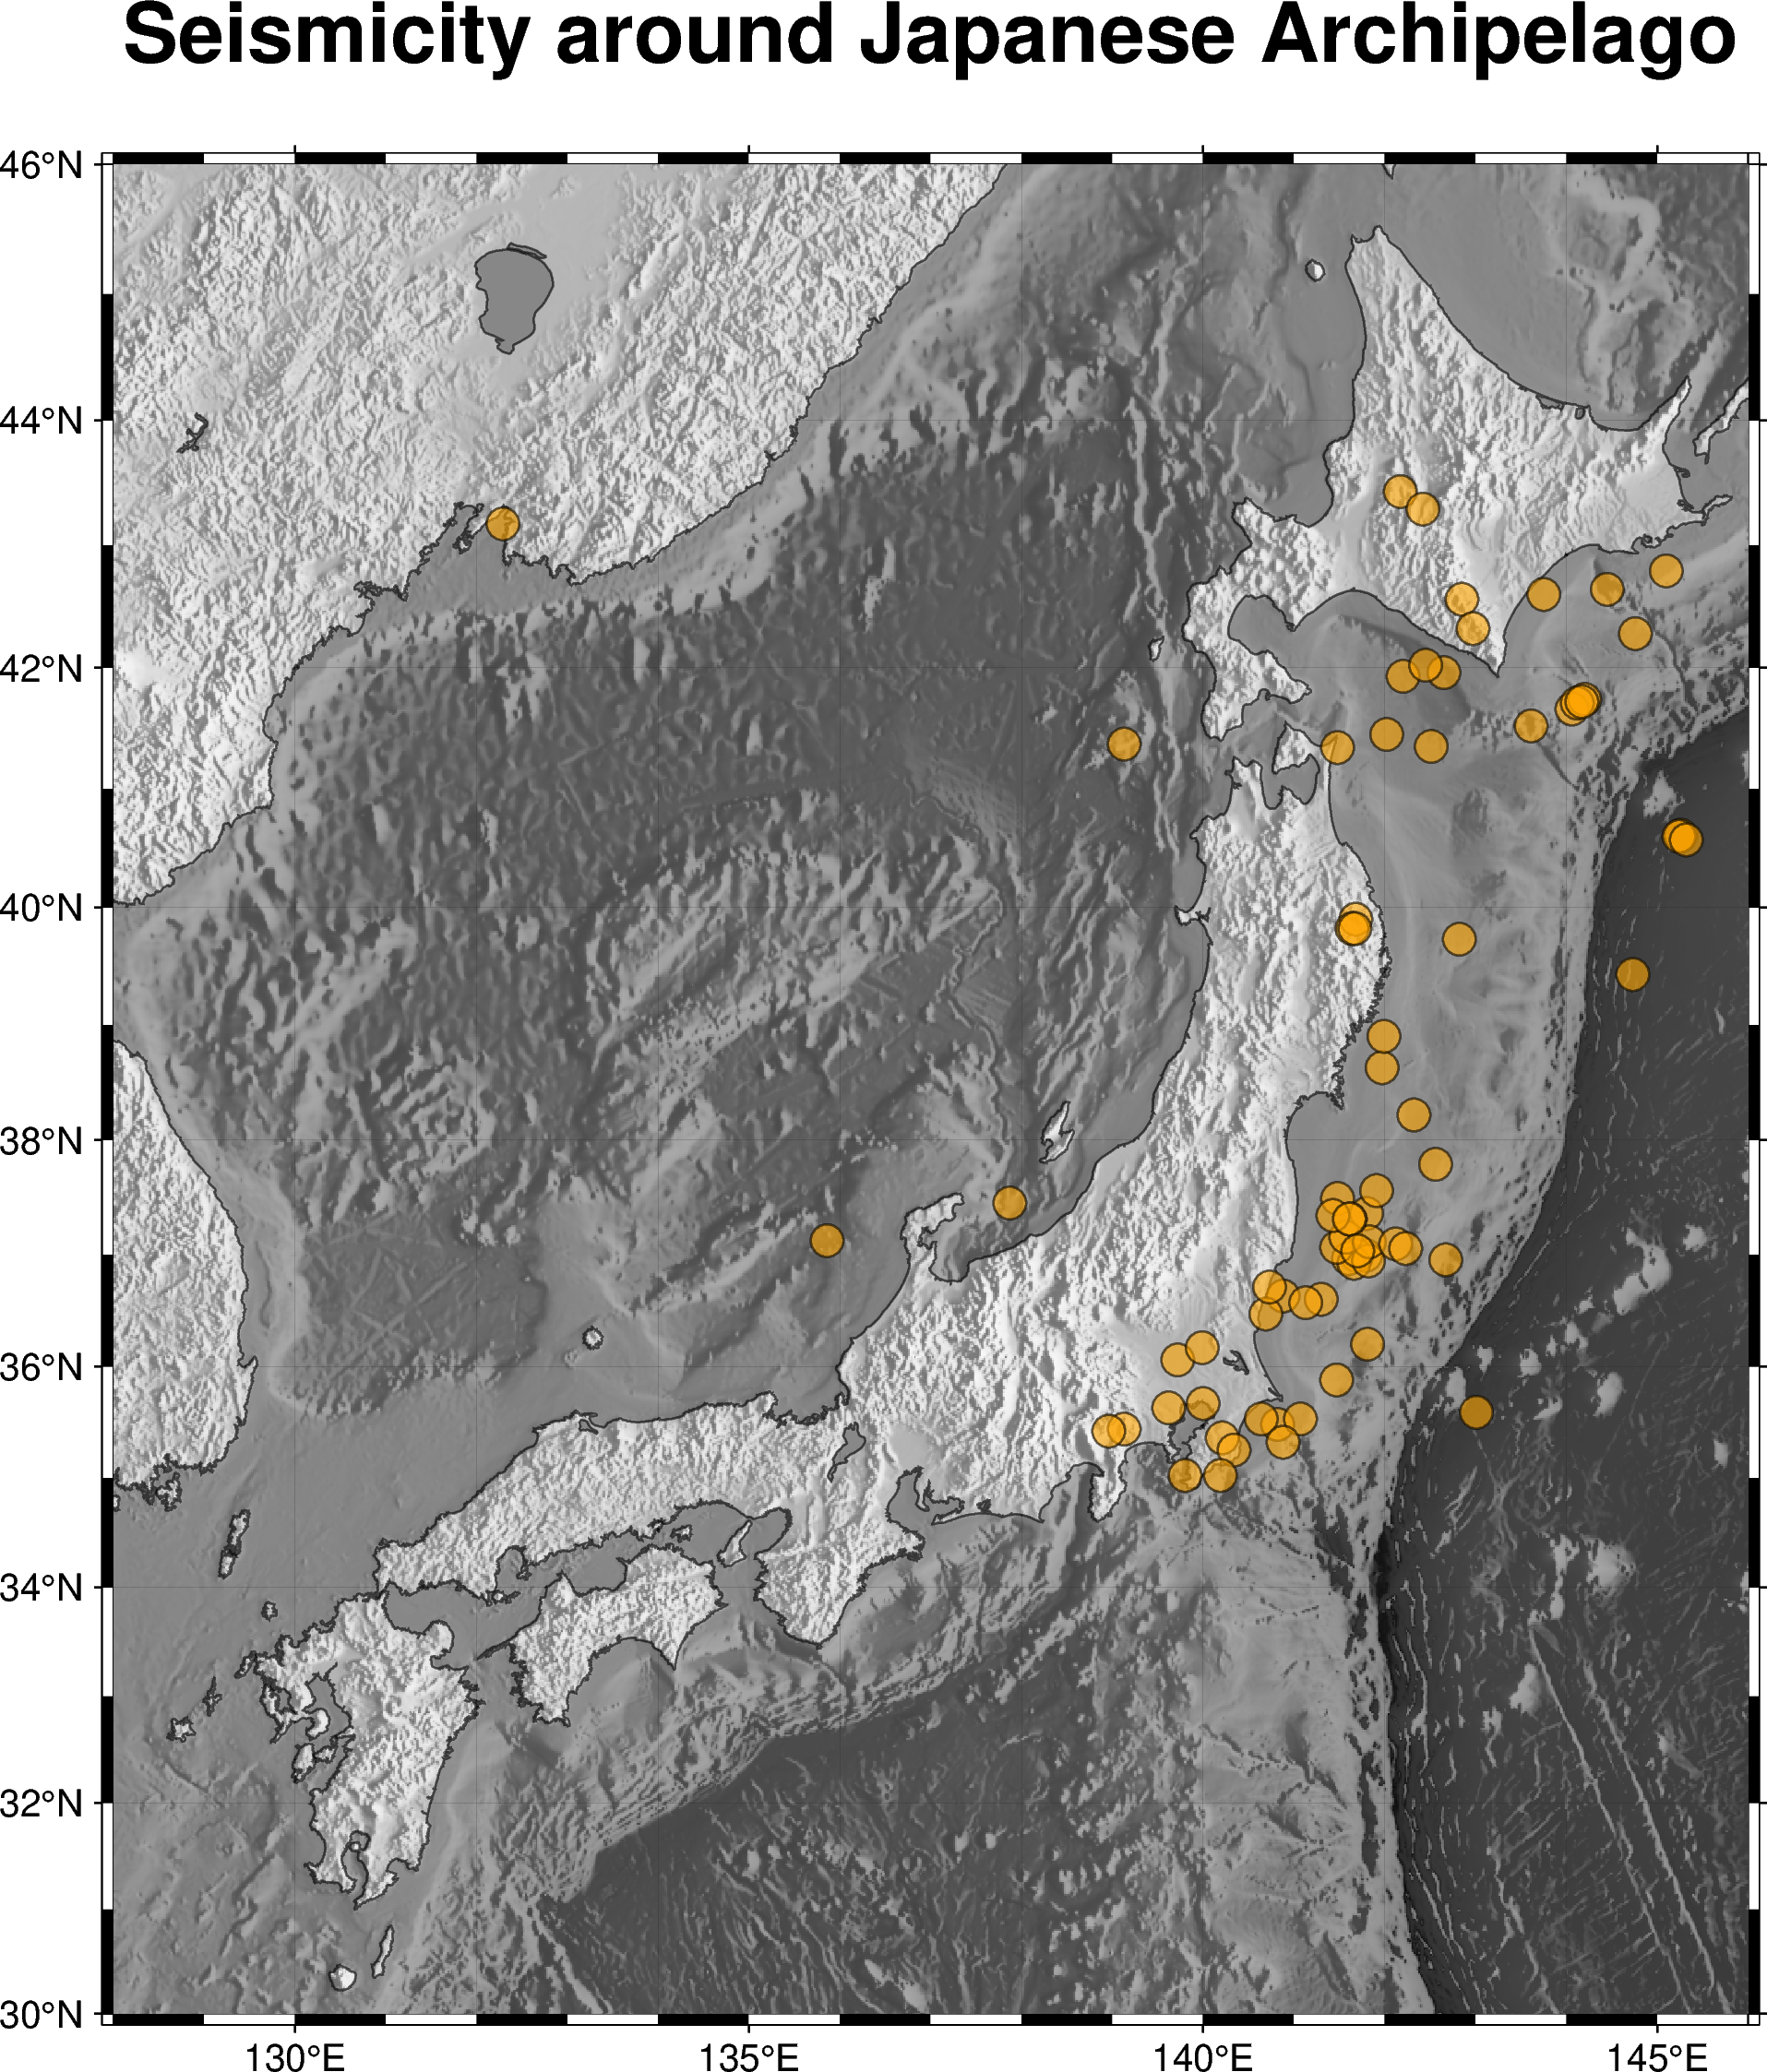

In [9]:
fig = pygmt.Figure()

fig.basemap(
    region     = [128, 146, 30, 46],
    projection = 'M15c', 
    frame      = ['WSen+t"Seismicity around Japanese Archipelago"', 'xaf', 'yaf'],
)

fig.grdimage(
    region   = [128, 146, 30, 46], 
    grid     = grid_data, 
    shading  = gradient_data,
    cmap     = 'gray'                   # 地震のほうを目立たせるため地形はモノクロに
)

fig.coast(
    shorelines  = 'thinner,black@40', 
    area_thresh = '100', 
    resolution  = 'h',
    water       = '30@70'               # 海域をすこし暗くする
)

# 震央分布のプロット
fig.plot(
    x            = hypdata.longitude,   # 横軸データ
    y            = hypdata.latitude,    # 縦軸データ
    color        = 'orange',               # 塗りつぶし色の指定
    style        = 'c0.3c',             # 固定サイズの場合は (symbol)(size) 指定
    pen          = 'thinner,black',     # 縁取りのペン
    transparency = 40                   # コマンド全体に影響する透明度設定
)

fig.show()

この図では，`tranparency` オプションでプロットするデータの透明度を指定しています．数値が100に近いほど透明に近くなっていきます．`tranparency`オプションの代わりに，色名やRGB値に

```python
color = 'red@60'
```
のように指定する方法もあります．この方法だと，たとえば塗りつぶしの色は半透明にするものの，`pen`オプションで指定する縁取りの線は不透明にする，というようなことも実現できます．

```{warning}

`transparency` オプションを `frame` を指定しているコマンドに付与すると，図の枠やラベルが半透明になってしまいます．半透明オプションの使い所には注意が必要です．
```

### 可変サイズ・可変色プロット

次に，マグニチュードと深さを用いてシンボルの色と大きさを変化させてみましょう．

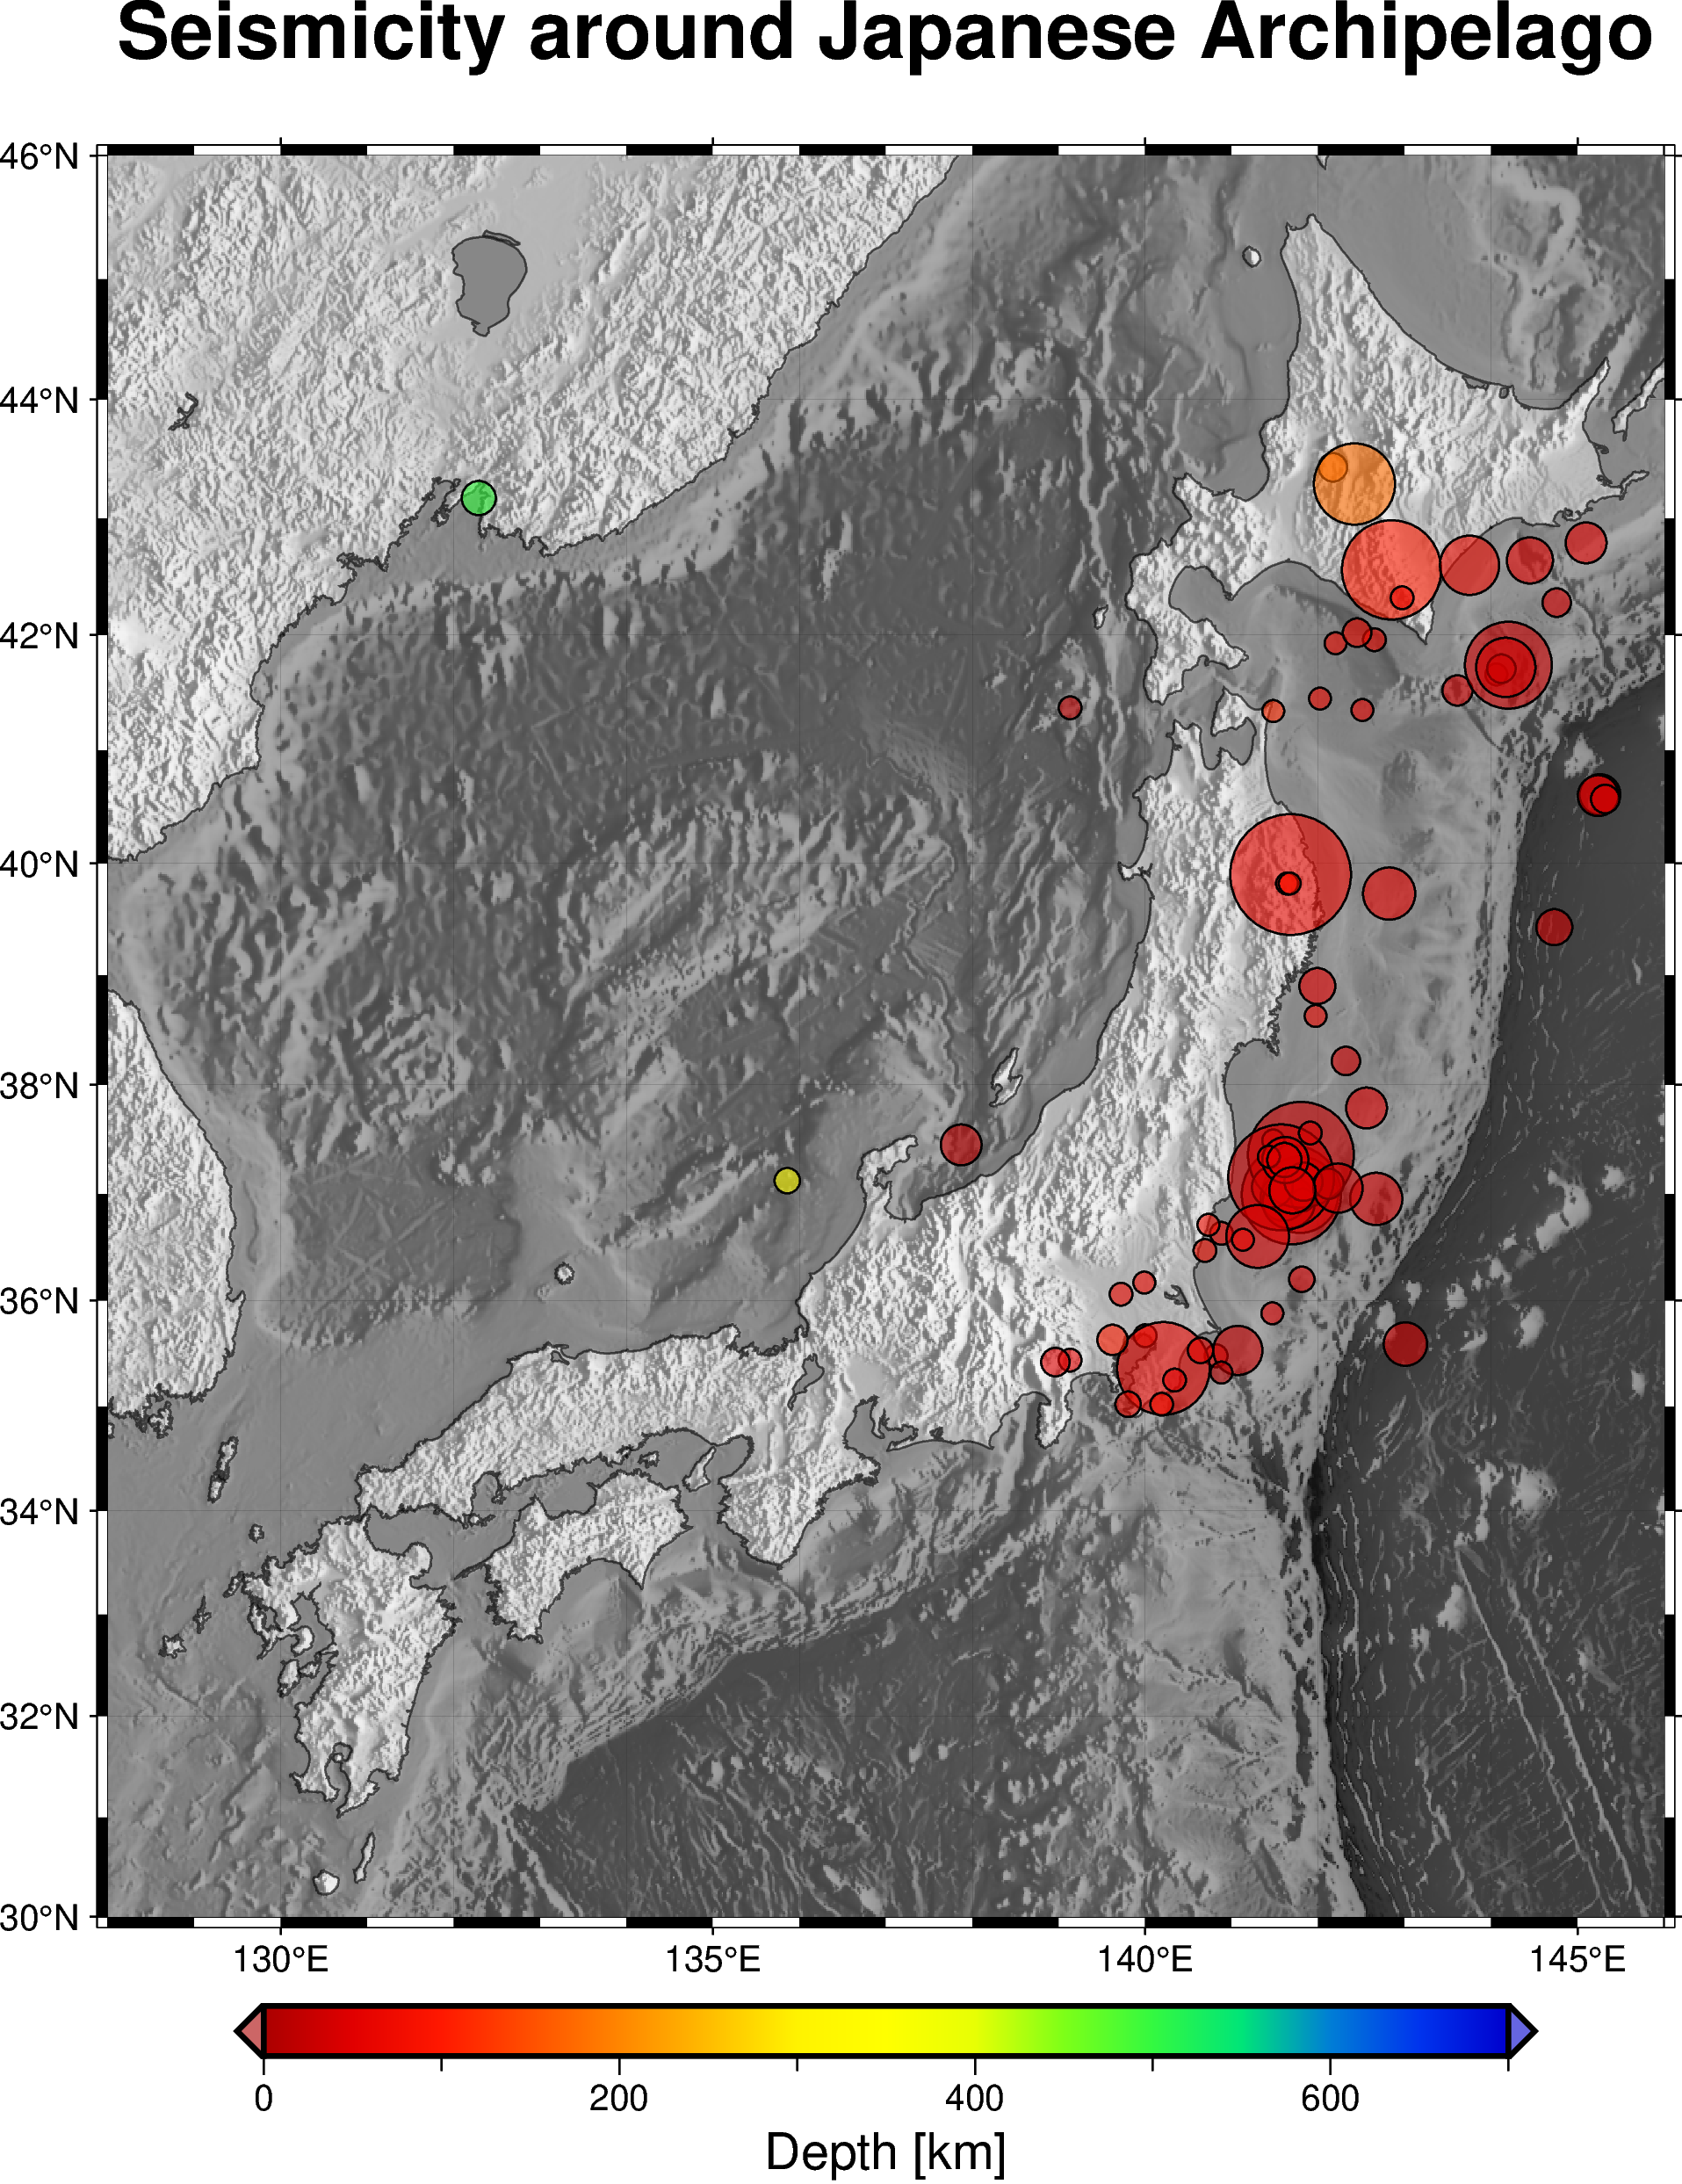

In [10]:
fig = pygmt.Figure()

fig.basemap(
    region     = [128, 146, 30, 46],
    projection = 'M15c', 
    frame      = ['WSen+t"Seismicity around Japanese Archipelago"', 'xaf', 'yaf'],
)

fig.grdimage(
    region     = [128, 146, 30, 46], 
    grid       = grid_data, 
    shading    = gradient_data,
    cmap = 'gray'
)

fig.coast(
    shorelines  = 'thinner,black@40', 
    area_thresh = '100', 
    resolution  = 'h',
    water       = '30@70'
)

pygmt.makecpt(
    cmap         = 'seis',        # カラーマップを選択
    series       = [0, 700, 50],  # min/max/increment
    background   = True,          # 値の上限・下限超過データの色を上限値・下限値と等しくする
    continuous   = True, 
    transparency = 40    
)

fig.plot(
    x     = hypdata.longitude,
    y     = hypdata.latitude,
    style = 'c',         
    pen   = 'thinner,black', 
    size  = 0.05 + 0.01 * (2**hypdata.magnitude),  # サイズ指定（cm）    
    cmap  = True,                                  # カラーマップ利用
    color = hypdata.depth_km,                      # 深さデータに基づき色を判断
)

fig.colorbar(
    position = '+e',
    frame    = ['x+l"Depth [km]"'], 
)


fig.show()

### カラーパレットの扱い

`pygmt.makecpt` でカラーパレットファイルを作成できます．
デフォルトでは，作成したカラーパレットがそのセッションの標準として登録され，それ以降のコマンドでのカラーパレットとして自動的に利用されます．

複数のカラーパレットを同時に使い分けたいなど，明示的にカラーパレットを指示したいときには，`pygmt.makecpt`  の `output` オプションでファイル名を指定して `.cpt` ファイルを作成することもできます．その場合には，`plot` コマンドの `cmap` オプションにはその `.cpt` ファイル名を指定します．

また，`fig.colorbar` は指定あるいは標準のカラーパレットに基づきカラースケールを描画します．位置指定を明示的にしない場合には，直前に描画した図の下部中央に配置されます．`frame` には数多くの指定ができるようですが，特に `+e`を指定すると，カラースケールの上限と下限を超えた値の色をカラースケール両側の三角形に示してくれます．


```{admonition} TODO
- 複数のカラーパレットを1枚の画像上の複数の絵にそれぞれ使うのであれば，`fig.subplot()` を用いるほうが便利そうだ．
- `colorbar` の位置指定の方法をまとめること．
```

## 時系列の扱い

震源分布に用いたデータから，地震発生日とマグにチュードからなる M-T 図を作成してみましょう．まずは`datetime`モジュールを用いて，震源カタログの年・月・日のデータをまとめて日付オブジェクトのリストにします．

In [11]:
hyptim = [datetime.datetime(yr, mo, dy) for yr, mo, dy in zip(hypdata.year, hypdata.month, hypdata.day)]
hypmag = hypdata.magnitude

ここではリスト`hyptim`を生成するのにPythonの内包表記を活用しています．この表現は，愚直に書くと

```python
hyptim = []
for yr, mo, dy in zip(hypdata.year, hypdata.month, hypdata.day):
    hyptim.append(datetime.datetime(yr, mo, dy))
```
と等価です．

また，`for`文に現れる `zip` 関数は複数のリスト（など）の要素をまとめる関数で，ループで変数 `yr`, `mo`, `dy` にそれぞれ `hypdata.year`，`hypdata.month`, `hypdata.day` から一つずつの要素を代入してくれます．．

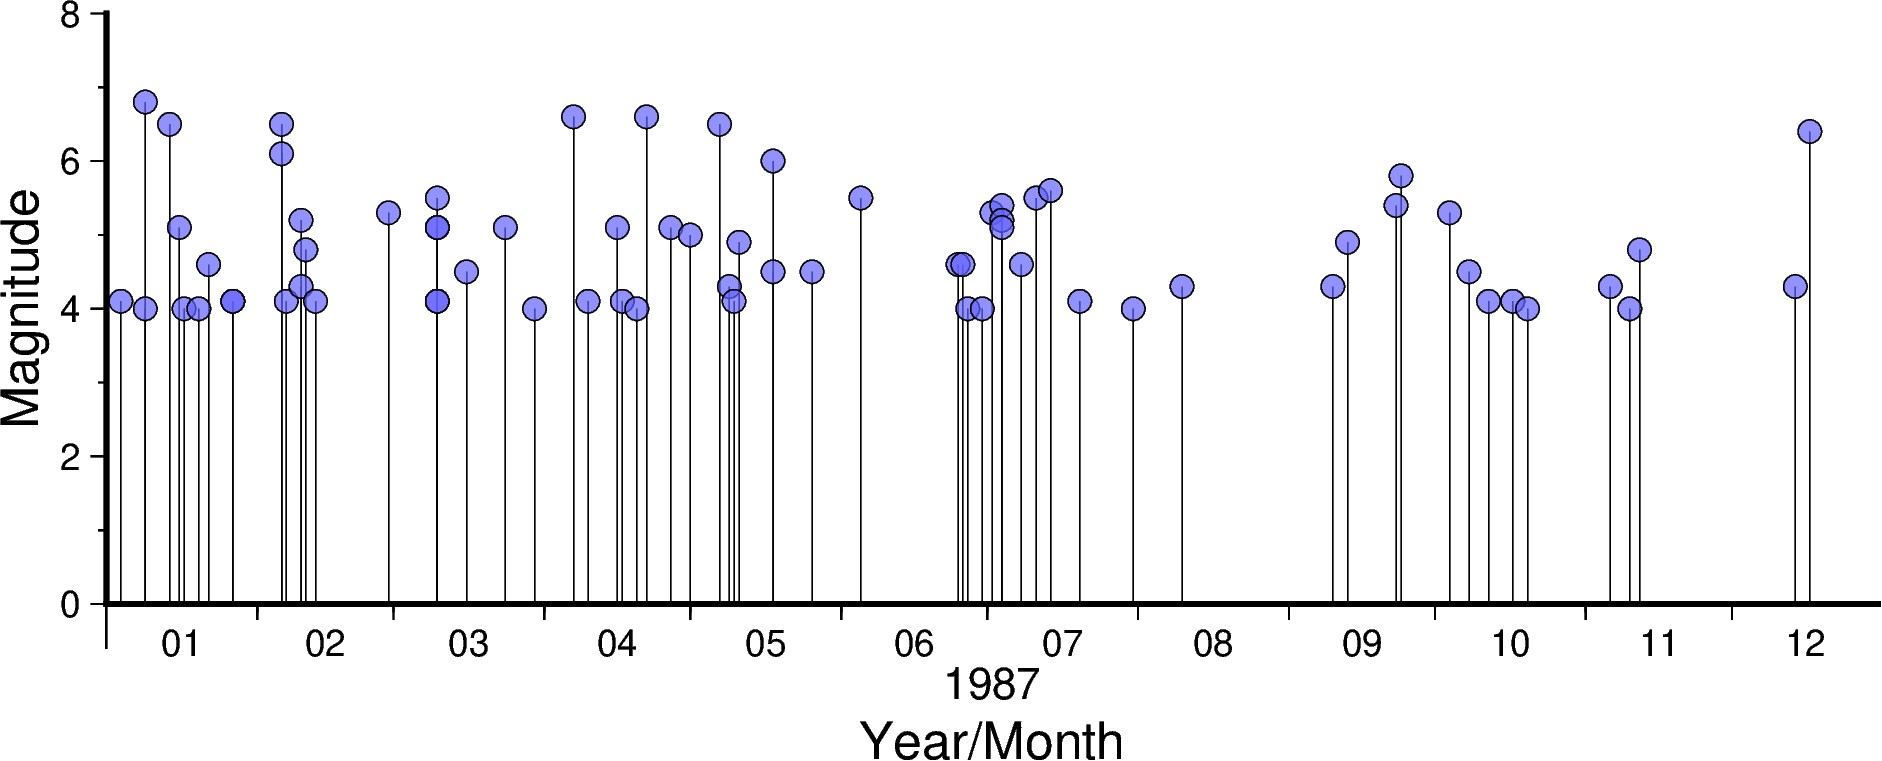

In [12]:
fig = pygmt.Figure()

fig.basemap(
    projection = 'X15c/5c', 
    region     = ['1987-01-01', '1987-12-31', 0, 8], 
    frame      = ['WS', 'pxa1o', 'sxa1Y+l"Year/Month"', 'yaf+l"Magnitude"']
)

for dy, mag in zip(hyptim, hypmag):
    
    fig.plot(
        x    = [dy, dy],
        y    = [0, mag],
        pen  = 'default,black'
    )
    

fig.plot(
    x     = hyptim, 
    y     = hypmag, 
    style = 'c0.2c', 
    color = '100/100/255@30', 
    pen   = 'default,black'
)

fig.show()

まず `fig.basemap` で枠を描画している．領域の横軸は `YYYY-MM-DD` の日付ISOフォーマットで指定している．`frame` については，横軸は軸のすぐそば（primary）に月名（`o`）を，少し離れて（secondary）年（`Y`）を描画している．このように二種類の軸情報を描画するには，`px` (primary) と `sx` (secondary) をそれぞれ指定する．

次のforループでは，準備してあった `datetime` 型の日付とマグニチュードから`zip`関数を用いてそれぞれ一つづつ抜き出し，縦棒を描画している．シェルスクリプトの場合は，区切り行（デフォルトは `>` が1文字目にある行）を用いて

```text
> 
1987-01-01 0
1987-01-01 5
>
1987-02-05 0
1987-02-05 4.5
>
...
```
のようなマルチセグメントデータを作って一斉にプロットできる．しかし，PyGMTにおいて変数受け渡しでマルチセグメントデータを`fig.plot`に渡す方法が今のところ不明なため，`for` 分で地震の個数回 `plot` 命令を発行するという力技で解決している．

## 等間隔メッシュデータ

次に，$z(x,y)$ のような形式で，$x$, $y$が等間隔のメッシュで与えられているデータを可視化してみましょう．

まず，サンプルとして NumPy で適当な等間隔データを作成してみます．

```{attention}
筆者がNumpyに詳しくないので，コンパイラ言語的な効率の悪い計算をしている気がします．
もっと効率の良い計算方法があったら教えて下さい．
```

In [13]:
nx = 500
ny = 500
x = np.linspace(0, 2, nx+1)
y = np.linspace(0, 2, ny+1)

In [14]:
z = np.zeros([nx+1, ny+1])

for i in range(nx):
    for j in range(ny):
        a = np.pi * ( x[i]    - np.sqrt(3.0) * y[j] )
        b = np.pi * ( 3.*x[i] + np.sqrt(3.0) * y[j] )
        z[i,j] = np.cos(2*a) * np.cos(4*b) + np.cos(5*a) * np.cos(3*b) + np.cos(7*a) * np.cos(b)

試しにmatplotlibでプロットしてみると，以下のような感じです．

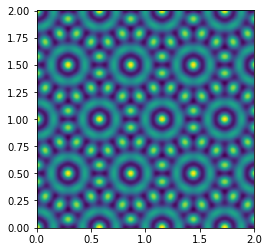

In [15]:
g = plt.subplot()
g.pcolormesh(x, y, z, shading='auto')
g.set_aspect('equal')

このデータを pygmt の `xyz2grd` を用いて grdデータにしてプロットしてみます．

````{note}
2021年12月現在，`xyz2grd` はx, y, zそれぞれ1次元配列にしないと渡せません．そのため，`np.meshgrid()`と `ravel()` メソッドを通じて `nx * ny` サイズの1次元配列を作っています．

もうすこしスッキリした書き方としては，`x`, `y`, `z`の代わりにそれらがパッキングされた`data`リストを内包表記を用いて以下のように与える方法もあります．
```python
pygmt.xyz2grd(
    data = [[x[i], y[j], z[i,j]] for i in range(len(x)) for j in range(len(y))]
    # 他の要素は省略
    )
```

ただし，この[Issue](https://github.com/GenericMappingTools/pygmt/pull/1566)を見る限り，おそらく近い将来にもとの `x[1:nx]`, `y[1:ny]`, `z[1:nx, 1:ny]` のデータを直接渡す事ができるようになりそう．そうすればもっと簡単にコードが書けるようになると思われます．
````

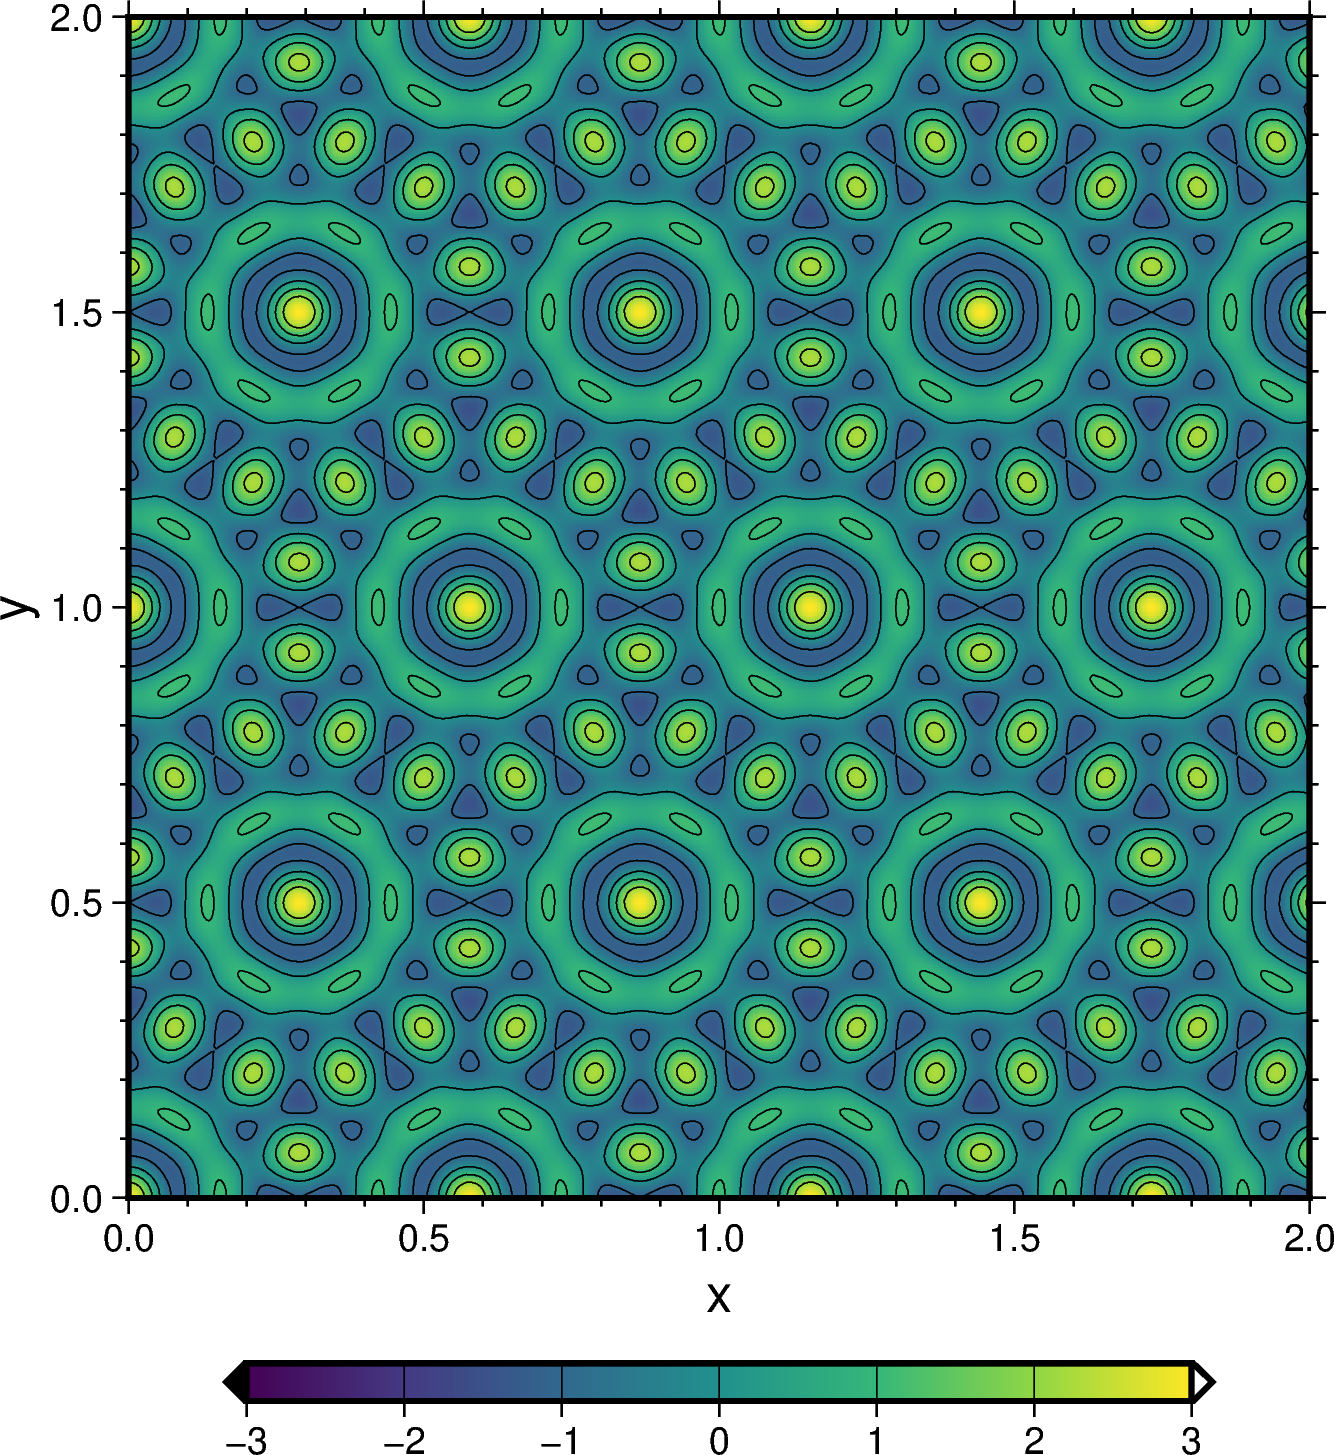

In [16]:
fig = pygmt.Figure()

X, Y = np.meshgrid(x, y)

grddata = pygmt.xyz2grd(
    region = [0, 2, 0, 2],     
    spacing = '0.004/0.004', 
    x = X.ravel(),
    y = Y.ravel(), 
    z = z.ravel()
)

pygmt.makecpt(
    cmap       = 'viridis',     # 比較のためカラーパレットはほとんど同じものを使う
    series     = [-3, 3, 1], 
    continuous = True
)

fig.grdimage(
    grid       = grddata, 
    projection = 'X10c/10c', 
    frame      = ['WSen', 'xaf+l"x"', 'yaf+l"y"'],    
)

fig.grdcontour(
    grid     = grddata, 
    interval = 1, 
    pen      = 'default,black'
)

fig.colorbar(
    position = '+e'    
)

fig.show()

## 2次元データの補間と可視化

続いて，粗いデータを補間しつつプロットしてみましょう．

サンプルデータとして，Wikipediaの[双3次補間](https://en.wikipedia.org/wiki/Bicubic_interpolation)の解説にある例を採用します．[ここ](https://commons.wikimedia.org/wiki/File:Interpolation-bicubic.svg)からコードをお借りして（Creditはリンク先参照；CC-BY），以下のようなデータを使います．まずはデータ生成とmatplolibでの標準的可視化の例を示します．

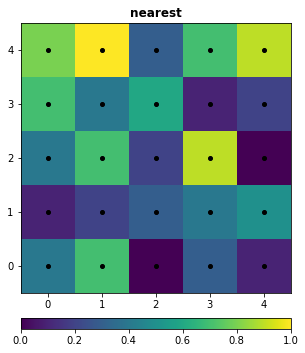

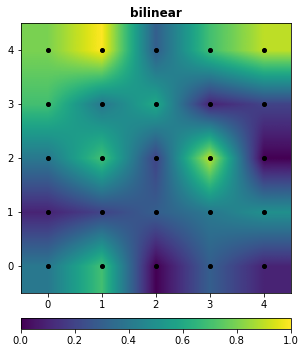

In [17]:
METHODS = [ 'nearest', 'bilinear' ]
COLORS  = 'viridis'

N = 5
np.random.seed(1)
grid = np.arange(0, N, 1)
data = np.round(np.random.rand(N, N), 1)
mesh = np.meshgrid(grid, grid)

for interp in METHODS:

    fig = plt.figure(figsize=(5,5))

    ax = fig.add_axes([0.125, 0.175, 0.75, 0.75])
    plt.imshow(data, interpolation=interp, cmap=COLORS, vmin=0, vmax=1)
    plt.plot(mesh[0], mesh[1], marker='.', ms=8, color='k', lw=0)
    plt.title(interp, weight='bold')
    plt.xlim(grid.min()-0.5, grid.max()+0.5)
    plt.ylim(grid.min()-0.5, grid.max()+0.5)
    plt.xticks(grid)
    plt.yticks(grid)

    cax = fig.add_axes([0.125, 0.075, 0.75, 0.03])
    cb = plt.colorbar(cax=cax, orientation='horizontal',
                      ticks=np.linspace(0, 1, 6))
    cb.solids.set_edgecolor('face')

ここで作られたデータを `ravel()`メソッド1次元化し，`pygmt.surface`で補間をしてみます．比較のため `pygmt.xyz2grd` で粗い間隔のままのプロットも作成します．

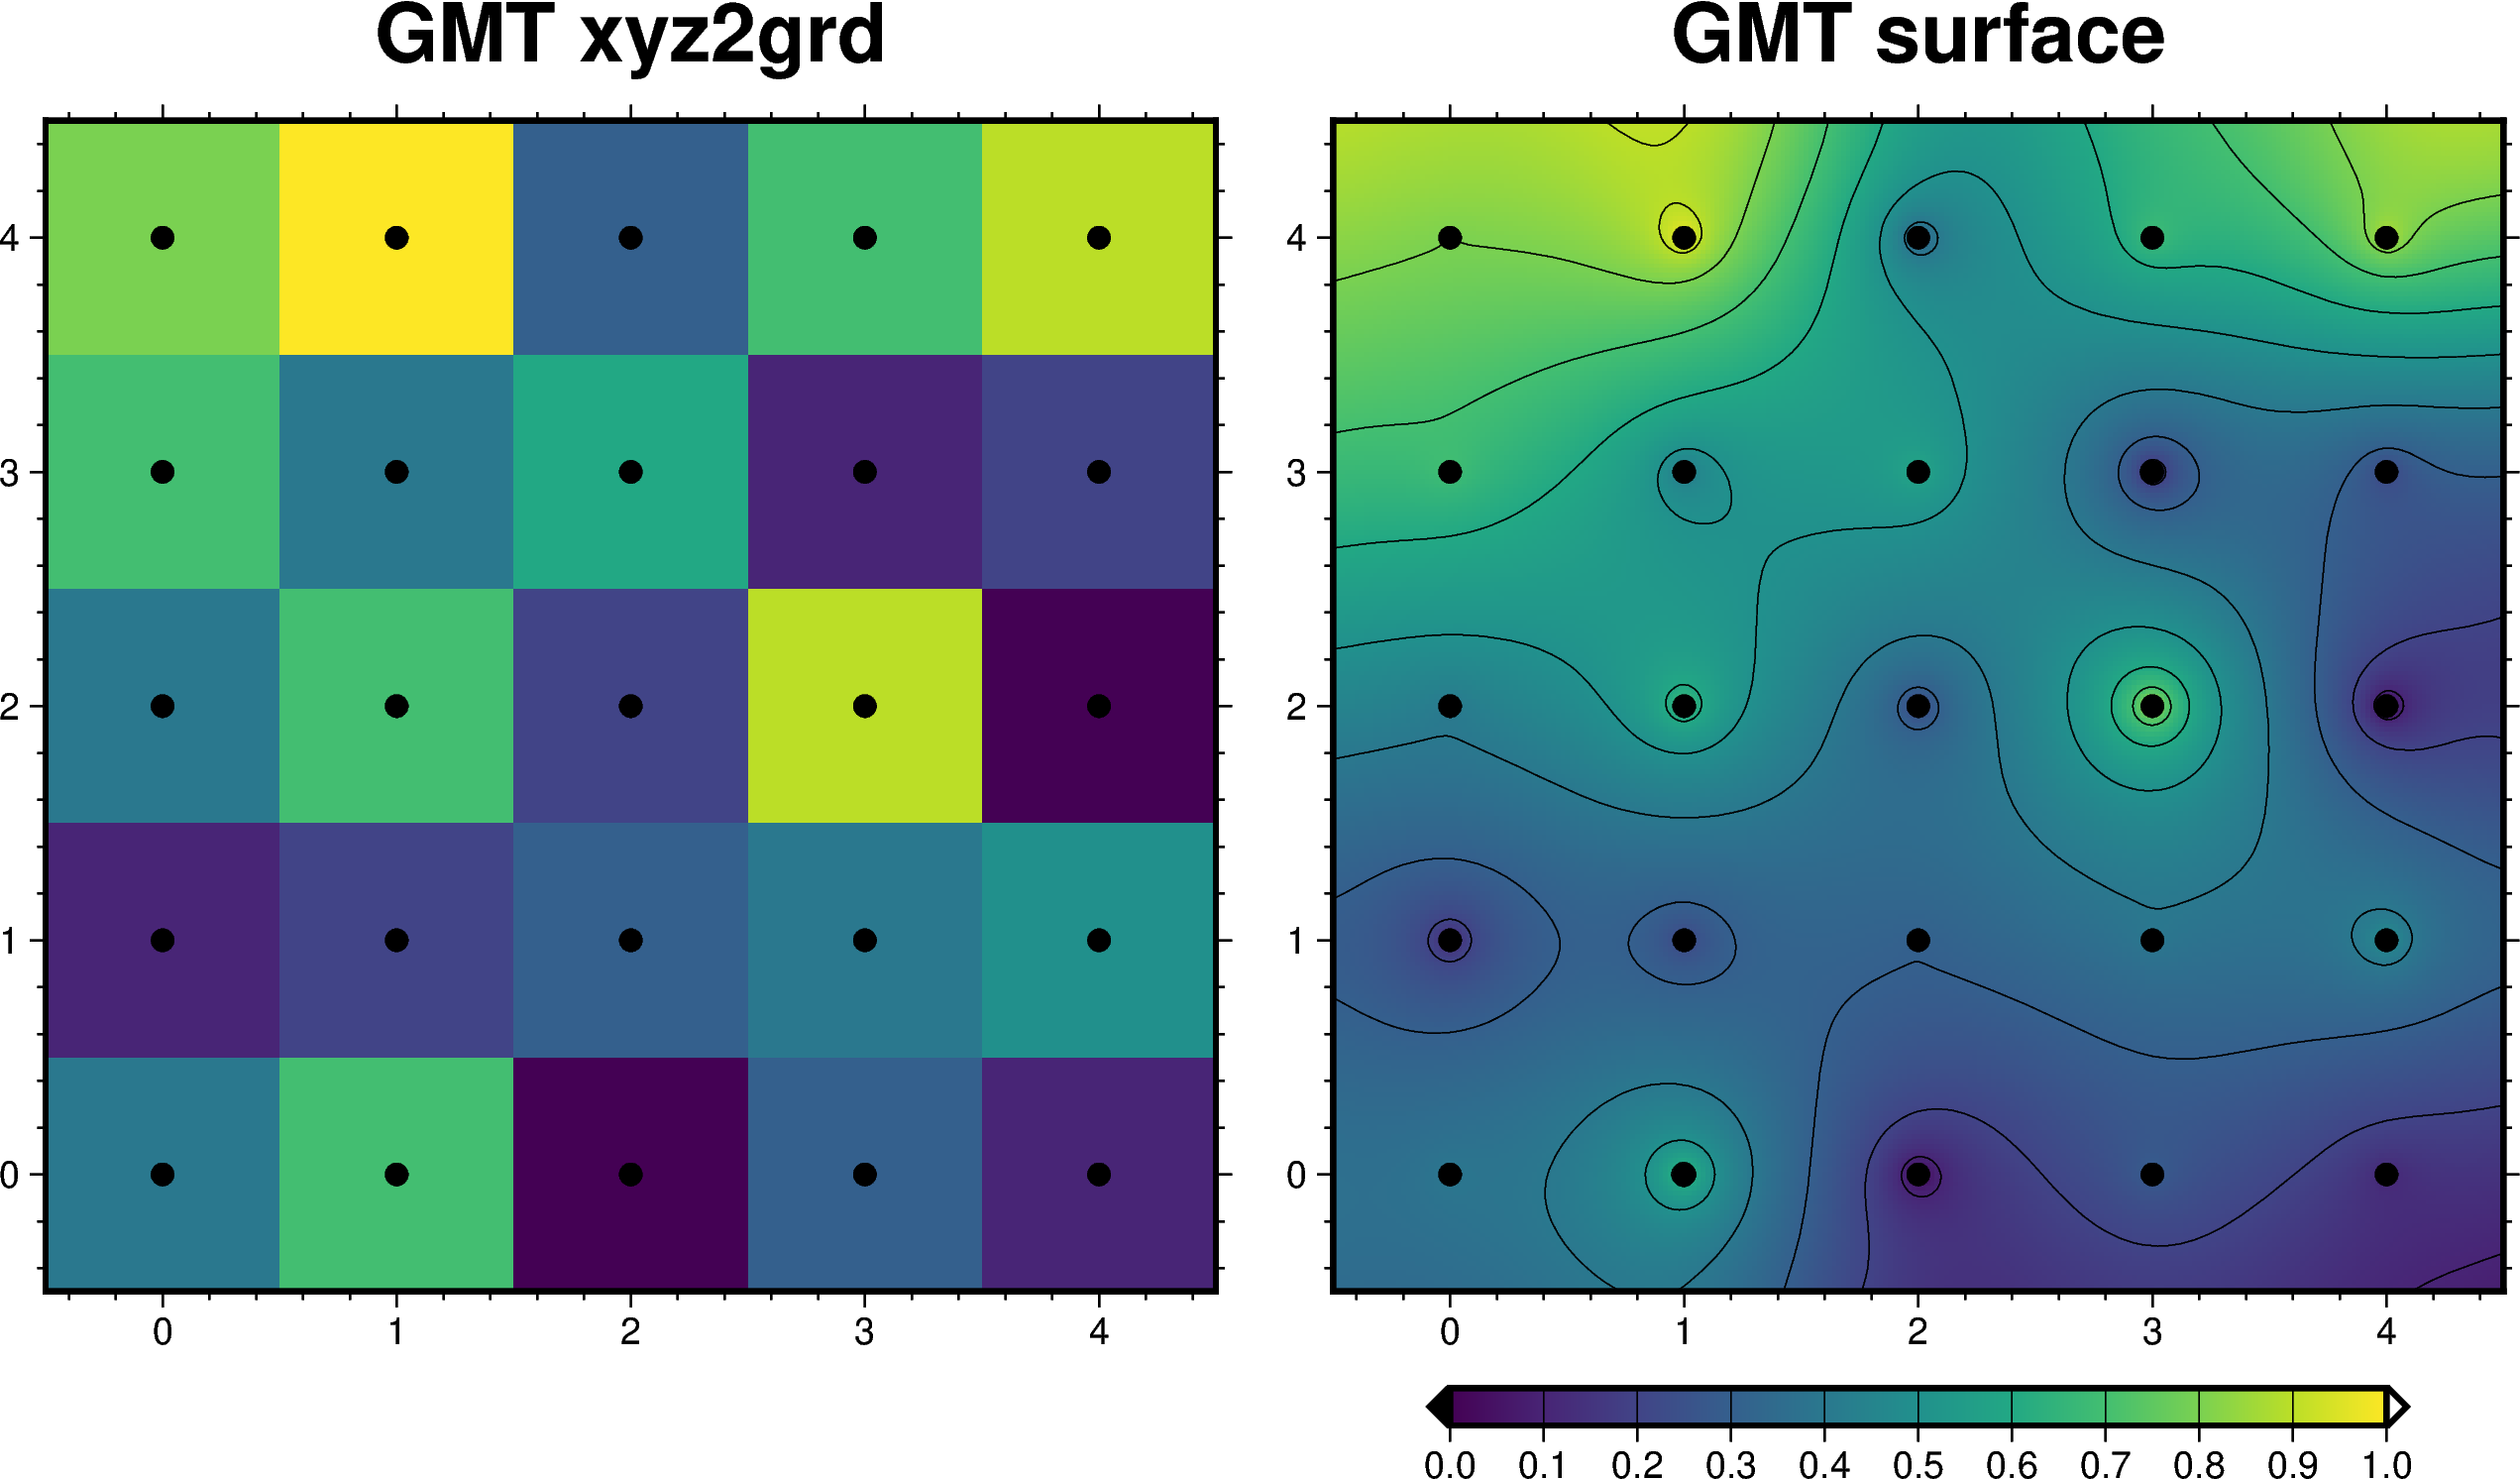

In [19]:
fig = pygmt.Figure()

griddata_s = pygmt.surface(
    x       = mesh[0].ravel(), 
    y       = mesh[1].ravel(), 
    z       = data.ravel(), 
    region  = [-0.5, 4.5, -0.5, 4.5], 
    spacing = '0.02/0.02',
    T       = 0.5 # tension 値．マニュアルにはまだないが動く．無指定は0
)

griddata_x = pygmt.xyz2grd(
    x       = mesh[0].ravel(), 
    y       = mesh[1].ravel(), 
    z       = data.ravel(), 
    region  = [-0.5, 4.5, -0.5, 4.5], 
    spacing = '1/1',
    registration = 'p'
)


pygmt.makecpt(
    cmap = 'viridis', 
    series = [0, 1, 0.1], 
    continuous = True
)

fig.grdimage(
    grid = griddata_x, 
    projection = 'X10c/10c',
    frame = ['WSen+t"GMT xyz2grd"', 'xaf', 'yaf'], 
)

fig.plot(
    x = mesh[0].ravel(), 
    y = mesh[1].ravel(), 
    style = 'c0.2c', 
    color = 'black', 
)

# 右にずれる
fig.shift_origin( xshift = 11 )

fig.grdimage(
    grid = griddata_s, 
    projection = 'X10c/10c',
    frame = ['WSen+t"GMT surface"', 'xaf', 'yaf']    
)

fig.grdcontour( 
    grid = griddata_s, 
    pen = 'default,black', 
    annotation = '-'
)

fig.plot(
    x = mesh[0].ravel(), 
    y = mesh[1].ravel(), 
    style = 'c0.2c', 
    color = 'black', 
)

fig.colorbar(
    position = '+e'    
)

fig.show()

```{note}
`pygmt.surface` は tension factor $t$ という量で補間の状況をコントロールします．しかし，その値を指定するオリジナルのGMTの `-T` オプションが，まだ PyGMTの公式マニュアルには記載されていません．
しかし，試みに `pygmt.surface{T = }` を実行したところ動作はするようです．
```

## GMTの微調整

GMTは `gmt defaults` コマンドでさまざまな調整を行うことができます．PyGMTでも同じことを実現する`pygmt.config`があります．

しかし，（シェルスクリプトによる従来のGMTでもそうなのですが）うかつに設定を変えると，同じスクリプト（シェルの場合は同じディレクトリ）で作成する他の図にも意図せず影響を及ぼしてしまうことがあります．

そこで，PyGMTではPythonの`with`構文を用いる方法が提案されています．以下の例は全く同じ図を`config`だけを変えてプロットしたものです．

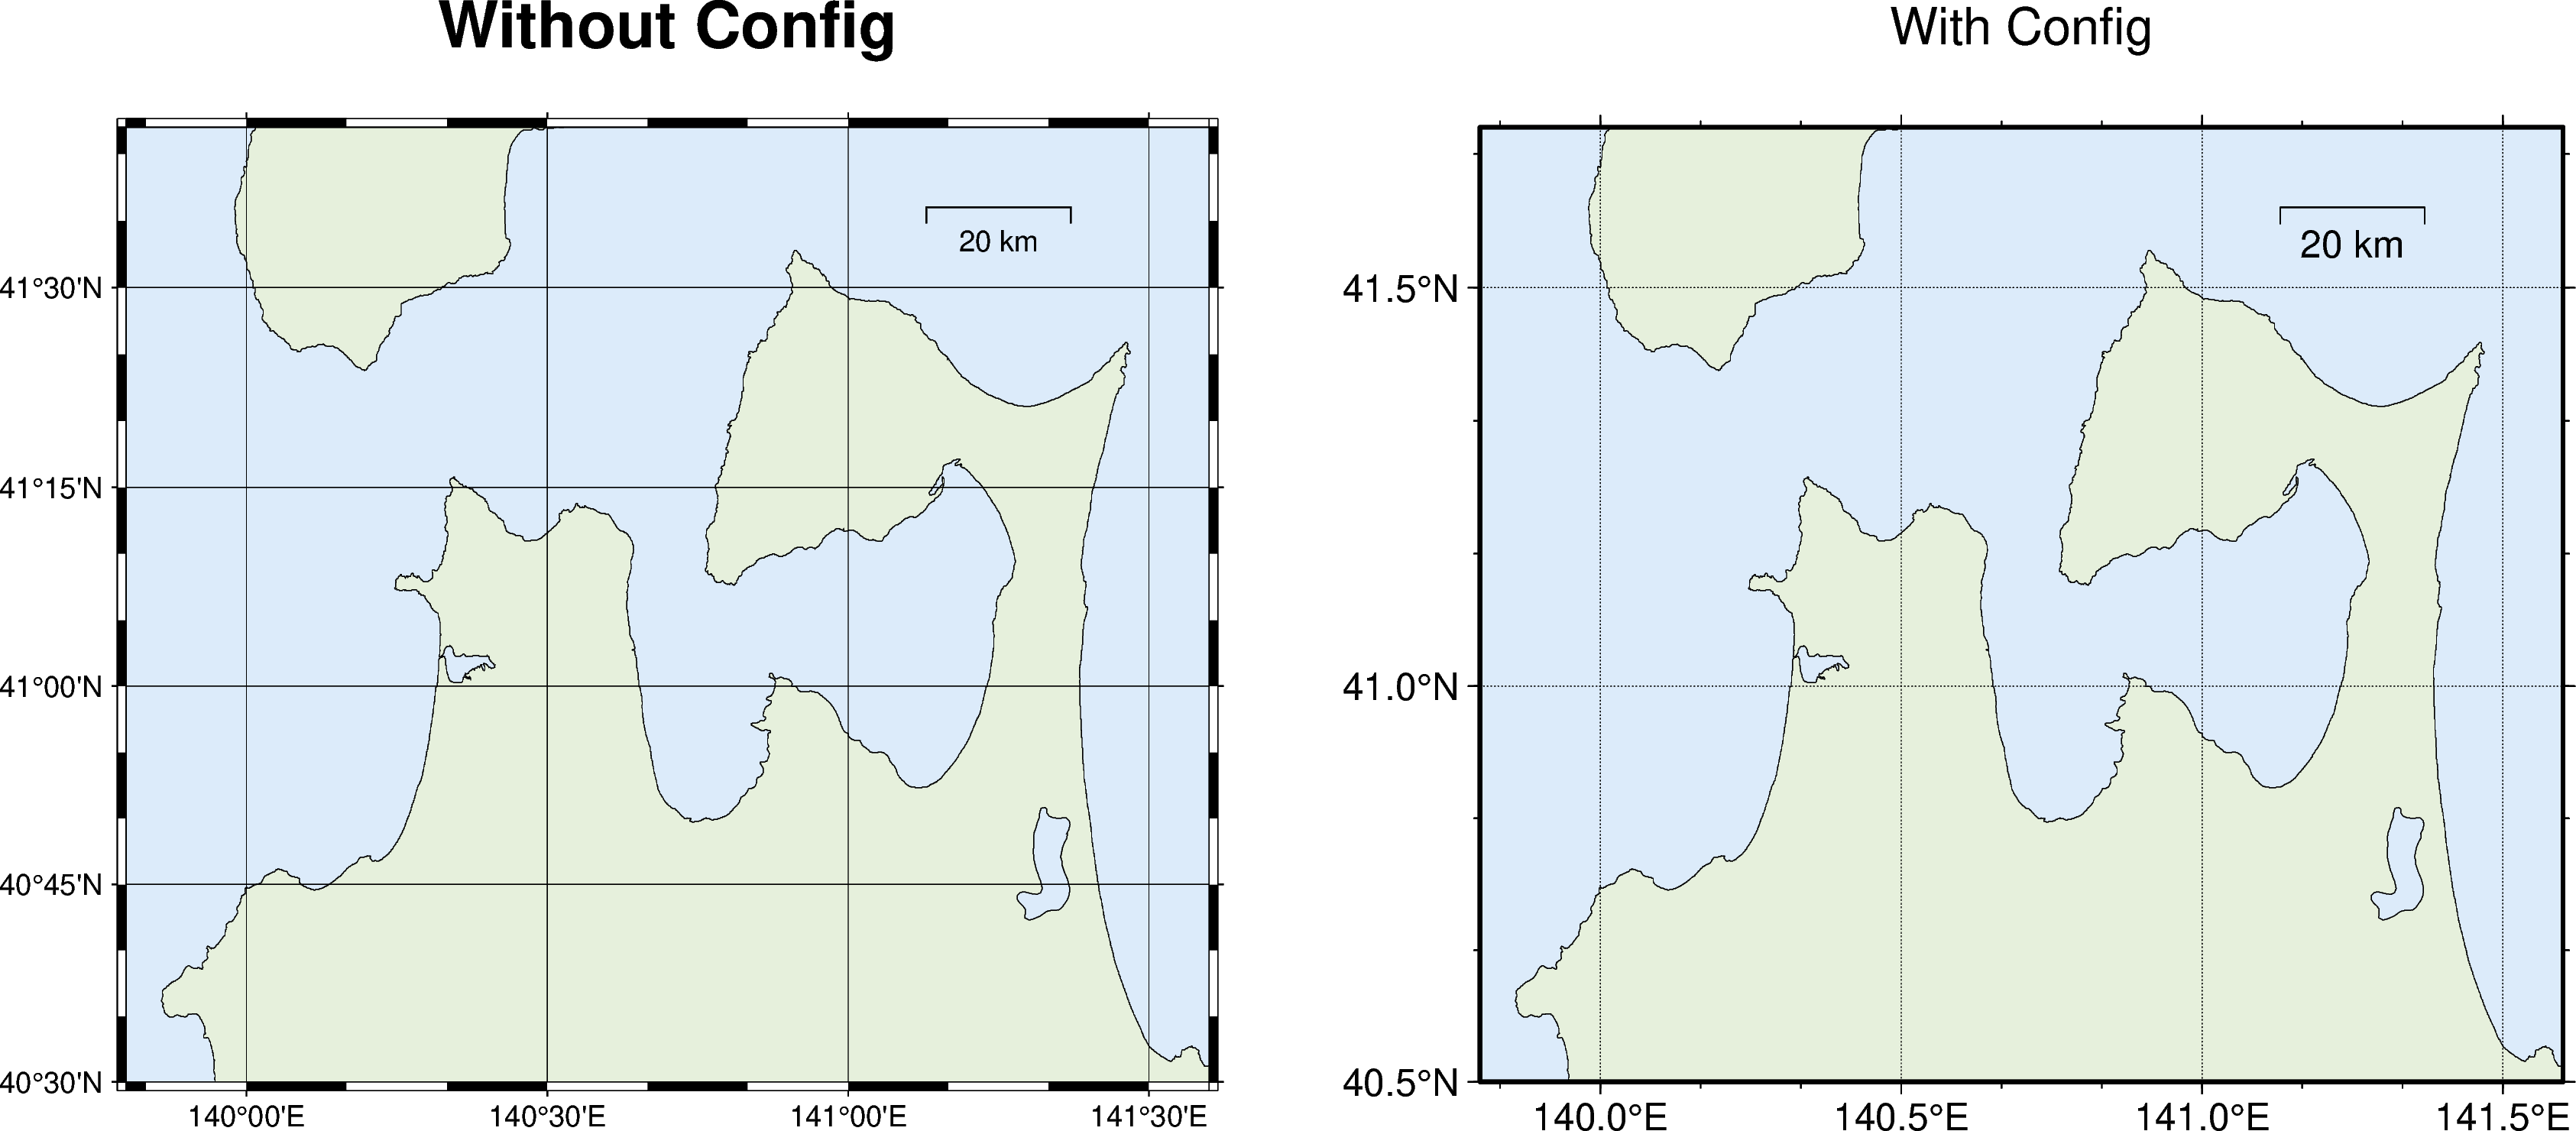

In [20]:
fig = pygmt.Figure()


fig.coast(
    projection  = 'M12c',                       
    region      =  (139.8, 141.6, 40.5, 41.7),  
    shorelines  = 'default,black',              
    area_thresh = 10,                           
    resolution  = 'f',                          
    land        = '230/240/220',                
    water       = '220/235/250',                
    map_scale   = '141.25/41.6/41.6/20',        
    frame       = ['WSen+t"Without Config"', 'xafg', 'yafg']
)

fig.shift_origin(xshift = 15)

with pygmt.config(
    FONT_ANNOT_PRIMARY   = '12p,Helvetica,black',
    FONT_ANNOT_SECONDARY = '11p,Helvetica,black',
    FONT_LABEL           = '14p,Helvetica,black',
    FONT_TITLE           = '16p,Helvetica,black',
    MAP_GRID_PEN_PRIMARY = '0.25p,30/30/30,.',
    MAP_FRAME_TYPE       = 'plain',
    FORMAT_GEO_MAP       = 'DF',
    FORMAT_FLOAT_OUT     = '%.1f',
    PS_IMAGE_COMPRESS    = 'none',
    PS_LINE_CAP          = 'round',
    PS_LINE_JOIN         = 'round'
):

    fig.coast(
        projection  = 'M12c',                      
        region      = (139.8, 141.6, 40.5, 41.7),  
        shorelines  = 'default,black',             
        area_thresh = 10,                          
        resolution  = 'f',                         
        land        = '230/240/220',               
        water       = '220/235/250',               
        map_scale   = '141.25/41.6/41.6/20',       
        frame       = ['WSen+t"With Config"', 'xafg', 'yafg']
    )


fig.show()

まったく同じ領域の地図を（タイトル以外）全く同じオプションでプロットしていますが，緯度経度の書式（時分秒か度か），それに伴い自動で設定されるラベルの間隔，フレームの種類，ラベルやタイトルのフォントやフォントサイズなどが異なっていることがわかるでしょう．

```{warning}
上記の地図のプロット順を逆にする（`with`でオプションありを先に描画）実験をしてみたところ，
ほとんどはうまく行ったが，グリッド線の線種（点線）だけは`config`なしの図にも反映されてしまいました．
もしかしたらこれはバグかもしれません．
```

## Obspyとの連携

SAC (Seismic Analysis Code) に含まれている地震波形例をファイルとして保存し，それをObsPyから読み込んでみ ましょう．SACでは以下のようなコマンドを実行することでサンプルファイルを作ります．

```bash
$ sac
 SEISMIC ANALYSIS CODE [10/13/2020 (Version 101.6a)]
 Copyright 1995 Regents of the University of California

SAC> funcgen seismogram
SAC> w dat/example.sac
SAC> quit
```

ObsPy で読み込むには `obspy.core.read` を使います．このコマンドは任意個数の地震波形を stream 形式という専用の型のリストに読み込みます．今回読み込むのは1波形だけなので，その最初の成分を `trace0` として抽出しましょう．

In [21]:
trace = obspy.core.read('./dat/example.sac')
trace0 = trace[0]

ObsPyは内部でmatplotlibと連携していて，波形に付随するメソッドの `plot` を使うだけで，波形を適当にプロットしてくれます．

In [ ]:
p = trace0.plot()

ObsPyで読み込んだ波形には，

- 波形振幅データ `trace0.data`
- 波形時刻情報 `trace0.times()`
- その他ヘッダ情報 `trace0.stats`

といった情報が含まれます．ObsPyは様々な波形データ形式に対応するなかで，今回はSAC形式の波形を読み込んでいるので，`trace0.stats.sac`という辞書に，SAC形式のヘッダが格納されています．

では，これを PyGMT で同じようにプロットしてみましょう．

In [ ]:
fig = pygmt.Figure()

fig.plot(
    projection = 'X20c/5c',
    region = [trace0.stats.starttime, trace0.stats.endtime, -2, 2],
    x = trace0.times("timestamp"), 
    y = trace0.data,
    pen = 'thick,50/50/150'
)

fig.text(
    text = "Station " + trace0.stats.station, 
    position = 'RT', 
    offset = 'j0.5c/0.5c',
    font = '12p,Helvetica-Bold,Black'
)

fig.basemap(
    frame  = ['WSen', 'xaf+l"time"', 'yaf+l"ampltude"' ],
)

fig.show()

基本的にこれまでに出てきたコマンドの組み合わせで実現できます．

特記すべきは`region` の横軸で，ObsPyのヘッダ（`stats`）に含まれる開始時間 `starttime` と 終了時間 `endtime` がそのまま `pygmt` の範囲指定に使えるのです．また，`fig.plot` に与える x軸データも，ObsPyの波形の時間情報 `trace0.times()` をそのまま与えることができます．

In [ ]:
fig = pygmt.Figure()

fig.plot(
    projection = 'X20c/5c',
    region = [0, trace0.stats.delta * trace0.stats.npts, -2, 2],
    x = trace0.times(), 
    y = trace0.data,
    pen = 'thick,50/50/150'
)

fig.text(
    text = "Station " + trace0.stats.station, 
    position = 'RT', 
    offset = 'j0.5c/0.5c',
    font = '12p,Helvetica-Bold,Black'
)

fig.basemap(
    frame  = ['WSen', 'xaf+l"time [s]"', 'yaf+l"ampltude"' ],
)

fig.show()

## メカニズム解の表現

メカニズムは辞書形式でデータを渡すのがわかりやすそうです．

In [ ]:
meca ={
    "strike"   : [35, 15], 
    "dip"      : [45, 35], 
    "rake"     : [90, 120], 
    "magnitude": [6, 4], 
    "longitude": [135, 140],
    "latitude" : [35, 40], 
    "depth"    : [30, 400]
}

この例のように，`strike, dip, rake` が指定されると自動的にAki and Richardsフォーマットが選択されます．公式マニュアルによると，その他のフォーマットは以下のような辞書項目が設定されていれば良いようです：

| format | dictionary keys |
|:------ |:---------------- |
| `aki`  | `strike`, `dip`, `rake`, `magnitude`  |
| `gcmt`  | `strike1`, `dip1`, `rake1`, `strike2`, `dip2`, `rake2`, `mantissa`, `exponent`  |
| `mt`  | `mrr`, `mtt`, `mff`, `mrt`, `mrf`, `mtf`, `exponent`  |
| `partial`  | `strike1`, `dip1`, `strike2`, `fault_type`, `magnitude`  |
| `principal_axis` | `t_exponent`, `t_azimuth`, `t_plunge`, `n_exponent`, `n_azimuth`, `n_plunge`, `p_exponent`, `p_azimuth`, `p_plunge`, `exponent`  |

複数のメカニズム解を表現したい場合は，辞書のそれぞれのキーに対応する値をリストやタプルにします．同じ構造を持つ辞書全体のリストを一括で処理することはできないようです．（とはいえ，Pythonの `for` 構文と組み合わせればそれは容易に実現できます）


残念ながら，辞書型での入力部分を除いて，PyGMTの `gmt meca` コマンドの実装はまだ十分とは言えない状況にあるようです（2021年12月現在）．
公式にサポートしているオプションはまだ全体のごく一部で，たとえば深さに応じて色を塗ることもできないように見えます．

しかし，実際には生の`gmt meca`オプションをほとんどそのまま指定できます．以下の例では`pygmt.makecpt`でカラーパレットを作成し，`fig.meca`には（マニュアルにはない）`C`オプションを引数空文字`''`で呼ぶことで，深さに応じた色を実現しています．

同じことは，`pygmt.makecpt` の `output`オプションで cpt ファイルを名前をつけて明示的に保存し，`fig.meca` の `C` オプションでそのファイル名を指定しても実現できます．ただし，そのcptファイルがカレントディレクトリに残骸として残ってしまいます．

In [ ]:
fig = pygmt.Figure()

fig.coast(
    projection  = 'M12c', 
    region      = [128, 146, 30, 46], 
    land        = 'grey', 
    water       = 'lightblue', 
    shorelines  = 'default,black', 
    area_thresh = 10,                           
    resolution  = 'f', 
    frame       = ['WSen', 'xaf', 'yaf'], 
    map_scale   = '142/31/31/500'
)

pygmt.makecpt(
    cmap         = 'seis',       
    series       = [0, 700, 50], 
    background   = True,         
    continuous   = True, 
    transparency = 40, 
)

fig.meca(spec  = meca, 
         scale = '1c', 
         C     = '',              # 従前に作ったカラーパレットを使う
)

# 節面を描画するにはもういちど fig.meca を `T` オプションをつけて呼ぶ
fig.meca(
    spec  = meca, 
    scale = '1c', 
    W = 'default,black', 
    T = '0'
)

fig.show()